# <span style="color:green"><center> Más sobre árboles: árboles de clasificación, Bagging, Random Forest, XGBoosting </center></span>

**Fernando Moreno, Frank Pedraza**

11 de noviembre 2022

## Introducción

La idea principal de los métodos estadísticos basados en árboles es segmentar el espacio de predictores en múltiples subregiones, cada una de las cuales contiene observaciones relativamente más homogéneas, con el fin que modelos más simples puedan ser usados en esas subregiones.

Debido a que muchas de la investigaciones de los métodos basados en árboles asumen que los datos son independientes, se requieren algunas modificaciones para tener en cuenta la estructura de dependencia en el contexto de series de tiempo y también algunas precauciones al implementar estos métodos.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import random 

In [2]:
import os
import random
import seaborn as sns
import sklearn

from tsmoothie.smoother import *
from tsmoothie.bootstrap import BootstrappingWrapper
from tsmoothie.utils_func import create_windows, sim_seasonal_data, sim_randomwalk

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
import tensorflow.keras as keras
from keras import Input, Model
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import math
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
#from kerashypetune import KerasGridSearch

import warnings
warnings.filterwarnings("ignore")

2022-12-01 15:15:58.794199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 15:15:58.881904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 15:15:58.881919: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-01 15:15:58.906558: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 15:15:59.373423: W tensorflow/stream_executor/platform/de

In [3]:
# para correr código R en colab
%load_ext rpy2.ipython

## Remesas de trabajadores, mensual

Unidad: Millones de USD

Fuente: Banco de la República

### Descripción de la serie

La serie consta de 271 realizaciones mensuales que van desde enero del 2000 a julio del 2022.

In [4]:
remesas = pd.read_csv(r'https://raw.githubusercontent.com/jofmorenore/TimeSeries/master/proyecto/datos/Serie%20agregada%20de%20Remesas%20de%20trabajadores.csv')
remesas['Fecha']=pd.to_datetime(remesas['Fecha'])
[remesas.shape, min(remesas['Fecha']), max(remesas['Fecha'])]

[(271, 2), Timestamp('2000-01-31 00:00:00'), Timestamp('2022-07-31 00:00:00')]

+ Convertir a objeto Series

In [5]:
remesas['Fecha']=remesas['Fecha'].dt.date - pd.offsets.MonthBegin()
remesas=pd.Series(remesas['Millones de USD'].values,remesas['Fecha'], name='remesas')
remesas.index.freq='MS'
remesas.head()

Fecha
2000-01-01    103.751344
2000-02-01    145.837278
2000-03-01    125.347269
2000-04-01    115.880748
2000-05-01    129.341871
Freq: MS, Name: remesas, dtype: float64

+ Gráfico de las serie

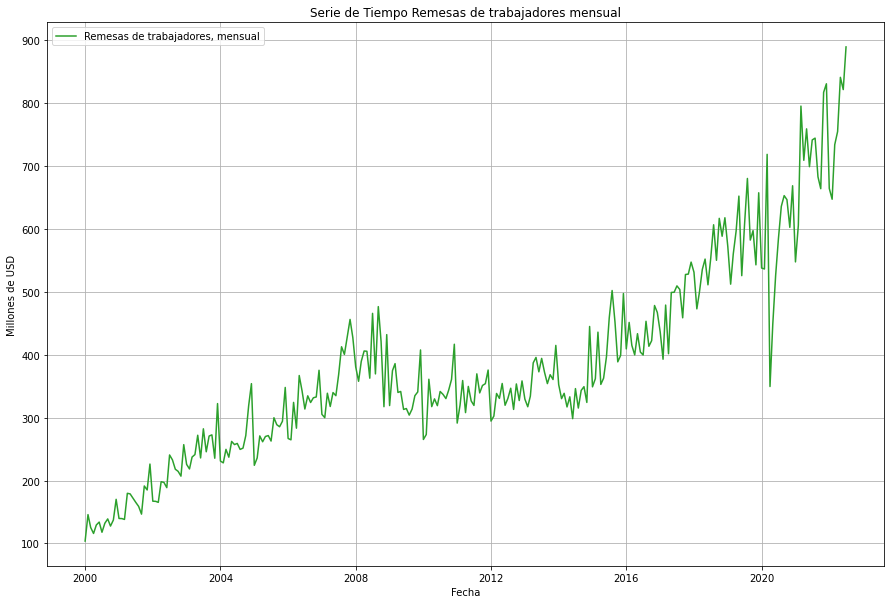

In [6]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(remesas, color='tab:green', label='Remesas de trabajadores, mensual')
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.set_title('Serie de Tiempo Remesas de trabajadores mensual')
ax.grid(True)
ax.legend(loc='upper left');

Al observar el gráfico de la serie lo primero que se evidencia es una tendencia creciente (la cual no parece ser una función suave), también se observa que la serie presenta indicios de varianza marginal no constante (en algunos instantes de tiempo la variabilidad parece ser mayor), por otra parte se concluye que la serie no estacionaria en el sentido débil, debido a que la media difiere a lo largo del tiempo, finalmente la serie parece no tener ciclo estacional, sin embargo más abajo a través de la serie diferenciada se determinará si hay presencia de ciclos ocultos en la serie.

### Estabilización en varianza

Al observar el gráfico de la serie, una de las primeras acciones que estaríamos tentados a hacer es transformar la serie a escala logarítmica, debido a que se manejan unidades en millones de USD y se busca estabilizar la varianza de la serie, Sin embargo para evaluar si es la transformación indicada se hará uso de la metodología basada en transformación de tipo Box-Cox, en la cual se estima un parámetro $\lambda$ a través de cualquiera de las dos formas (loglik y guerrero) en las que está implementada en el software.

+ **Transformación Box-Cox**

In [7]:
import scipy as sp
import scipy.stats 
sp.stats.boxcox(remesas,alpha=0.05) #(0.058, 0.522) #Data must be positive

(array([ 9.76761319, 11.1344932 , 10.51008057, 10.19681686, 10.63722743,
        10.78210855, 10.26142549, 10.72354002, 10.93330437, 10.5831735 ,
        10.87940283, 11.79897059, 10.9550986 , 10.94927701, 10.90979771,
        12.04240013, 12.019185  , 11.84493574, 11.67260959, 11.50008528,
        11.15714431, 12.32601601, 12.1736716 , 13.10733419, 11.72165756,
        11.71543741, 11.67325283, 12.48606965, 12.45977641, 12.26210348,
        13.4065363 , 13.24659283, 12.93100314, 12.85863014, 12.68804634,
        13.7306921 , 13.09632121, 12.94087697, 13.33907647, 13.41930171,
        14.01372878, 13.30996076, 14.2012351 , 13.50837309, 13.99040861,
        14.02445844, 13.30013851, 14.8917562 , 13.20827222, 13.1474622 ,
        13.58475318, 13.33466417, 13.82897646, 13.73312792, 13.7675962 ,
        13.58285802, 13.62353223, 14.0044453 , 14.83397619, 15.39562494,
        13.06509909, 13.309225  , 13.99416495, 13.81909129, 13.97691438,
        14.00392368, 13.84013454, 14.5125496 , 14.3

In [8]:
%%R
library(forecast)
#library(FitAR) # genera error en colab

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [9]:
# -i pasar los datos de entorno python a R (analogamente -o: pasar los datos de entrono R a python)
%R -i remesas

In [10]:
%%R 
forecast::BoxCox.lambda(remesas, method = "guerrero", lower = -1, upper = 3)

[1] 0.08589458


Dado que la estimación de $\lambda$ a través de los dos métodos (loglik y guerreo) lleva a la misma concluisón $\lambda > 0$, la transformación para estabilizar la varianza en este caso es la siguiente:

$$ f_{\lambda}(r_{t}) = \lambda^{-1} (r_{t}^{\lambda}-1)) \quad\text{donde $r_t$: remesas en el tiempo $t$}$$


In [11]:
lambdaest = 0.08589458
bc_remesas=sp.stats.boxcox(remesas,lmbda=lambdaest).rename('BC_remesas')
remesas2 = pd.concat([remesas, bc_remesas], axis=1)
remesas2.head()

,remesas,BC_remesas
Fecha,,
2000-01-01,103.751344,5.703735
2000-02-01,145.837278,6.218536
2000-03-01,125.347269,5.987766
2000-04-01,115.880748,5.869252
2000-05-01,129.341871,6.035336


In [12]:
%R -i remesas2

Ahora usamos la misma función para verificar si en verdad la varianza fue estabilizada, en este caso $\lambda$ da un valor cercano a 1 con lo cual se verifica que la tranformación Box-Cox implementada fue la adecuada.

In [13]:
%%R
forecast::BoxCox.lambda(remesas2$BC_remesas, method = "guerrero", lower = -1, upper = 3)

[1] 1.075401


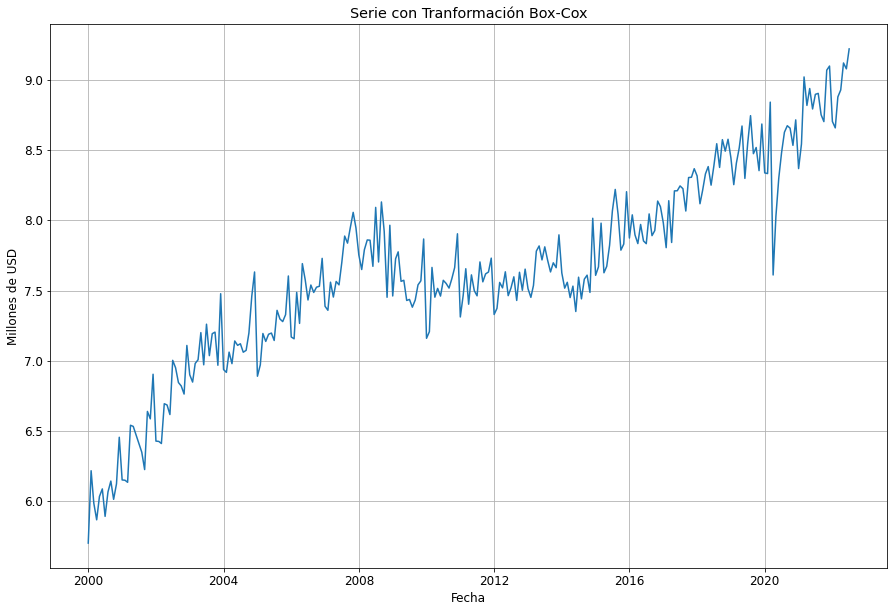

In [14]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(remesas2['BC_remesas'])
plt.title('Serie con Tranformación Box-Cox') 
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.grid(True)
plt.show()

In [15]:
%%R
#install.packages("rlang", version = "1.0.3")
#install.packages("timetk")
library(timetk)
library(lubridate)
library(dplyr)
library(lessR)
library(fpp3)

R[write to console]: 
Attaching package: ‘lubridate’


R[write to console]: The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
lessR 4.2.3                         feedback: gerbing@pdx.edu 
--------------------------------------------------------------
> d <- Read("")   Read text, Excel, SPSS, SAS, or R data file
  d is default data frame, data= in analysis routines optional

Learn about reading, writing, and manipulating data, graphics,
testing means and proportions, regression, factor analysis,
customization, and descriptive statistics from pivot tables.
  Enter:  browseVignettes("lessR")

View changes in this and recent versions of lessR.
  Enter: news(package=

In [16]:
%%R
remesas2$Fecha = rownames(remesas2)
remesas2$Fecha = ymd_hms(remesas2$Fecha)
remesas2$Mes = month(remesas2$Fecha, label = TRUE)

In [17]:
%%R
rms = ts(remesas2$BC_remesas, frequency = 12, start = c(2000, 1))       

In [18]:
%%R
#remesas2_stl <- rms %>%
#  model(stl = STL(rms))
    
#remesas2_stl %>%
#  components() %>%
#  autoplot()

NULL


### Eliminación de la tendencia

A continuación se busca eliminar la tendencia lineal de la serie de Remesas, diferenciando la serie de forma ordinaria una sola vez.

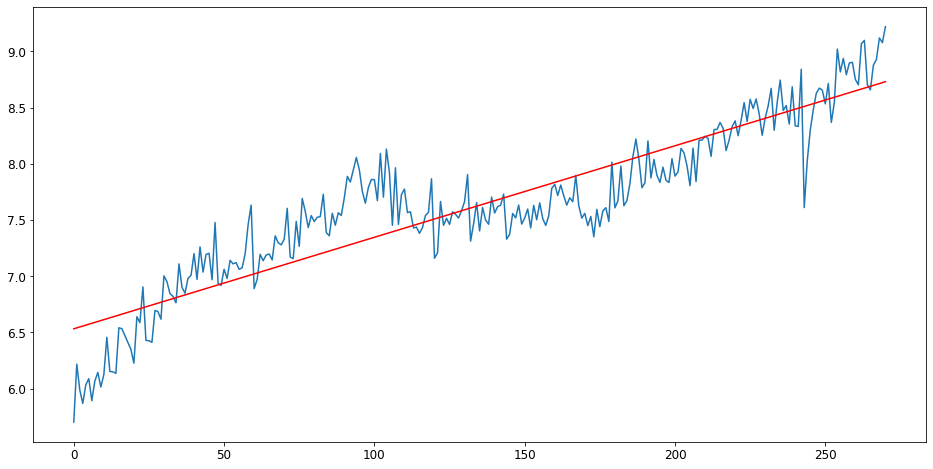

El coeficiente para el modelo planteado es de [0.09764956].
El intercepto del modelo planteado es -188.76619167864305.


In [19]:
from sklearn.linear_model import LinearRegression
X1=np.arange(2000+0/12,2022+7/12,1/12) # Donde comienza la serie, donde termina y la frecuencia que tiene
X=X1
X = np.reshape(X, (len(X), 1))
y = remesas2['BC_remesas'].values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.figure(figsize=(16,8))
plt.plot(y)
plt.plot(trend, color='red')
plt.show()
print('El coeficiente para el modelo planteado es de {}.'.format(model.coef_))
print('El intercepto del modelo planteado es {}.'.format(model.intercept_))

In [20]:
# se ajusta un modelo para chequear la relación lineal
X = sm.add_constant(X)
linmodel = sm.OLS(y, X)
results = linmodel.fit()
print(results.summary())
ypred = results.predict(X)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1241.
Date:                jue, 01 dic 2022   Prob (F-statistic):          8.76e-103
Time:                        15:16:03   Log-Likelihood:                -54.925
No. Observations:                 271   AIC:                             113.9
Df Residuals:                     269   BIC:                             121.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -188.7662      5.574    -33.864      0.0

In [21]:
dif_remesas=remesas2['BC_remesas'].diff(periods=1).rename('st_remesas')

<class 'pandas.core.series.Series'>


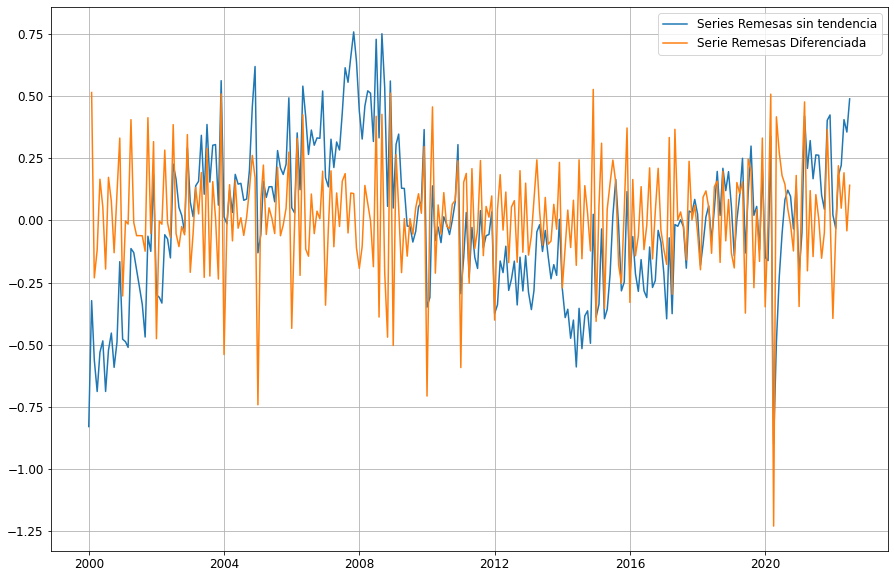

In [22]:
# Gráfica detrend
dt = [y[i]-trend[i] for i in range(0, len(remesas2['BC_remesas']))]
remesas_dt = pd.Series(dt, index = remesas2['BC_remesas'].index).rename('dt_remesas')
#print(remesas_dt)
print(type(remesas_dt))
# plot detrended
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(remesas_dt, label = 'Series Remesas sin tendencia')
ax.plot(dif_remesas, '-', label="Serie Remesas Diferenciada")
ax.grid(True)
ax.legend(loc="best");
plt.show()

### Gráficos ACF y PACF

In [23]:
%R -i remesas_dt

In [24]:
%%R
remesas2$dif_remesas = remesas_dt
#dif_rms = ts(na.omit(dif_remesas), frequency = 12, start = c(2000, 2))       

In [25]:
%%R
#remesas2_stl <- remesas2 %>%
#  model(stl = STL(remesas2))
    
#remesas2_stl %>%
#  components() %>%
#  autoplot()

NULL


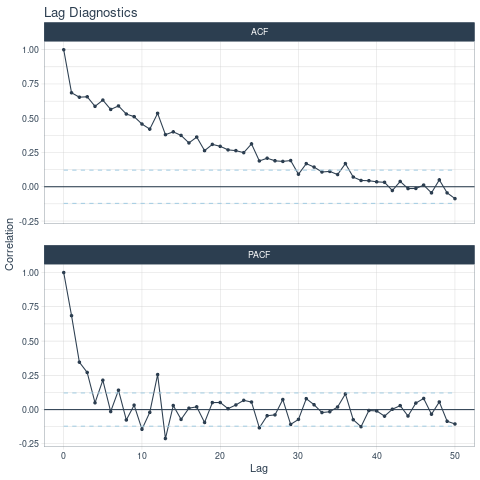

In [26]:
%%R
remesas2%>%timetk::plot_acf_diagnostics(
       Fecha, remesas_dt,               # ACF & PACF
        .lags = 50,          # 7-Days of hourly lags
        .interactive = FALSE)

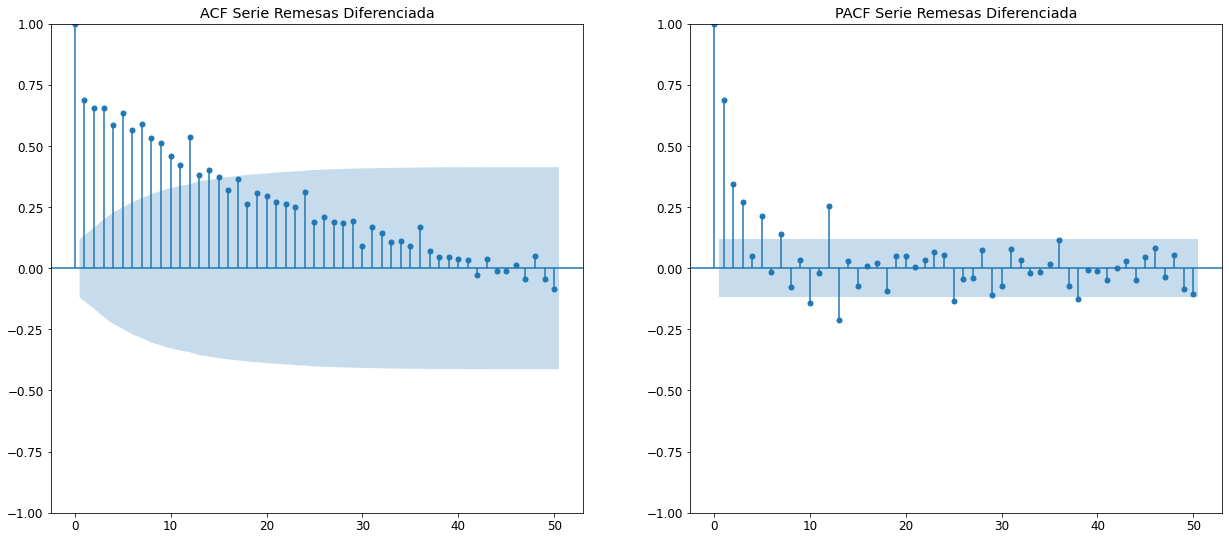

In [27]:
fig, ax = plt.subplots(1,2,figsize=(21,9))
plot_acf(remesas_dt,adjusted=False,lags=50,ax=ax[0],title='ACF Serie Remesas Diferenciada')
plot_pacf(remesas_dt,lags=50,ax=ax[1],title='PACF Serie Remesas Diferenciada', method='ywmle')
plt.show()

Tanto en el gráfico de la función de autocorrelación (ACF) como en el PACF se evidencia que los rezagos 1 y 12 tienen un valor alto lo que sugiere una fuerte asociación estadística tanto negativa como postiva respectivamente, además se observa que hay rezagos de ordenes grandes para los cuales los valores de la ACF caen por fuera del intervalo de confianza para un modelo MA, sin embargo por el contexto del problema no hace sentido que la remesas de 15,20,25 o 30 meses atrás influencien lo que ocurre con las remesas en el mes actual, se procede a ajustar modelos AR(12) y MA(12) puros.

In [28]:
remesas3 = pd.concat([remesas2, remesas_dt], axis=1)
remesas3 = pd.DataFrame(remesas3['dt_remesas']).dropna()
remesas2 = pd.DataFrame(remesas2['remesas'])
remesas3.head()

,dt_remesas
Fecha,
2000-01-01,-0.829192
2000-02-01,-0.322529
2000-03-01,-0.561436
2000-04-01,-0.688088
2000-05-01,-0.530142


## **Creación de variables rezagadas**

In [29]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()

for i in range(12,0,-1):
    df1[['t-'+str(i)]] = remesas3.shift(i)
    df2[['t-'+str(i)]] = remesas2.shift(i)
    
#df1 = df1.dropna()

In [30]:
# Create column t
df1['t'] = remesas3.values
df2['t'] = remesas2.values
df1 = df1.dropna()
df2 = df2.dropna()
df1.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
Fecha,,,,,,,,,,,,,
2001-01-01,-0.829192,-0.322529,-0.561436,-0.688088,-0.530142,-0.484440,-0.687902,-0.522433,-0.453076,-0.591015,-0.489188,-0.165821,-0.477620
2001-02-01,-0.322529,-0.561436,-0.688088,-0.530142,-0.484440,-0.687902,-0.522433,-0.453076,-0.591015,-0.489188,-0.165821,-0.477620,-0.487895
2001-03-01,-0.561436,-0.688088,-0.530142,-0.484440,-0.687902,-0.522433,-0.453076,-0.591015,-0.489188,-0.165821,-0.477620,-0.487895,-0.510545
2001-04-01,-0.688088,-0.530142,-0.484440,-0.687902,-0.522433,-0.453076,-0.591015,-0.489188,-0.165821,-0.477620,-0.487895,-0.510545,-0.112974
2001-05-01,-0.530142,-0.484440,-0.687902,-0.522433,-0.453076,-0.591015,-0.489188,-0.165821,-0.477620,-0.487895,-0.510545,-0.112974,-0.129214


+ **Dividir los datos**

In [31]:
#Entrenamiento, validacion y prueba
X1=df1.values[:, 0:-1] 
y1=df1.values[:, -1] 
X2=df2.values[:, 0:-1] 
y2=df2.values[:, -1] 

In [32]:
X_trainF, X_test, y_trainF, y_test = train_test_split(X1,y1,test_size=0.2, train_size=0.8, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_trainF, y_trainF, test_size = 0.2, train_size = 0.8, shuffle=False)

In [33]:
X_trainF2, X_test2, y_trainF2, y_test2 = train_test_split(X2,y2,test_size=0.2, train_size=0.8, shuffle=False)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_trainF2, y_trainF2, test_size = 0.2, train_size = 0.8, shuffle=False)

In [34]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(165, 12) (165,)
(52, 12) (52,)


## Árboles de decisión

In [35]:
from sklearn.ensemble import  BaggingRegressor # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
DT_remesas =  BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
DT_remesas.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_samples=100,
                 n_estimators=500, n_jobs=-1)

In [36]:
# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",DT_remesas.score(X_train, y_train))
print("Coeficiente R2 sobre el conjunto de prueba:",DT_remesas.score(X_test,y_test))  # predictions are horrible if negative value, no relationship if 0
print("el RECM es:",(((DT_remesas.predict(X_test)-y_test)**2).sum())**0.5)

Coeficiente R2 sobre el conjunto de entrenamiento: 0.8952528458094162
Coeficiente R2 sobre el conjunto de prueba: 0.10349975682536716
el RECM es: 1.6124809676665985


In [37]:
# Predict values for train and test
train_prediction = DT_remesas.predict(X_trainF)
test_prediction = DT_remesas.predict(X_test)

print(train_prediction.size)
print(X_trainF.size)

print(test_prediction.size)
print(y_test.size)

207
2484
52
52


In [38]:
idx_test=df1.index
print(idx_test.size)  ###Tamaño del índice
indicetrain=idx_test[0:207]
indicetest=idx_test[207:259]

259


In [39]:
targetjoint=np.concatenate((y_trainF,y_test))
predictionjoint=np.concatenate((train_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

259
259


In [40]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=idx_test)
ObsvsPred.head()

,observado,Predicción
Fecha,,
2001-01-01,-0.477620,-0.339748
2001-02-01,-0.487895,-0.380894
2001-03-01,-0.510545,-0.412346
2001-04-01,-0.112974,-0.283950
2001-05-01,-0.129214,-0.171820


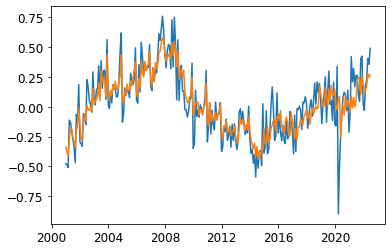

In [41]:
plt.plot(ObsvsPred)

In [42]:
import statistics as stats
stats.mean((ObsvsPred["observado"] - ObsvsPred["Predicción"])**2)

0.020163417992615413

### Devolviendo a la escala original

In [43]:
ObsvsPred['observado'] = [ObsvsPred['observado'][i]+trend[i+12] for i in range(0, len(ObsvsPred['observado']))]
ObsvsPred['observado'] = sp.special.inv_boxcox(ObsvsPred['observado'].values, lambdaest) # inversa de Box-Cox
ObsvsPred.head()

,observado,Predicción
Fecha,,
2001-01-01,139.723638,-0.339748
2001-02-01,139.528352,-0.380894
2001-03-01,138.209131,-0.412346
2001-04-01,179.730618,-0.283950
2001-05-01,178.800381,-0.171820


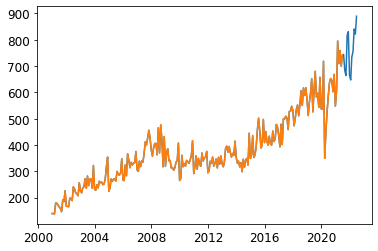

In [44]:
# chequeo que la inversa si arroja la serie original
d1 = {'observado': ObsvsPred['observado'], 'Serie': remesas.iloc[12:259]}
ObsvsPred1=pd.DataFrame(data=d1,index=idx_test)
plt.plot(ObsvsPred1)

In [45]:
ObsvsPred['Predicción'] = [ObsvsPred['Predicción'][i]+trend[i+12] for i in range(0, len(ObsvsPred['Predicción']))]
ObsvsPred['Predicción'] = sp.special.inv_boxcox(ObsvsPred['Predicción'].values, lambdaest) # inversa de Box-Cox
ObsvsPred.head()

,observado,Predicción
Fecha,,
2001-01-01,139.723638,152.859475
2001-02-01,139.528352,149.615769
2001-03-01,138.209131,147.362684
2001-04-01,179.730618,161.011583
2001-05-01,178.800381,173.981399


### Gráfico del ajuste en la escala original de la serie

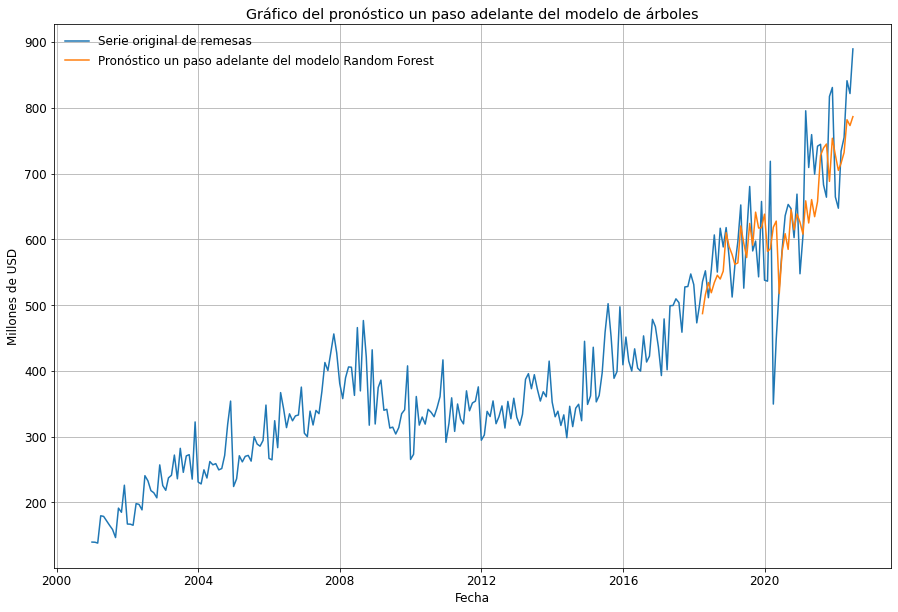

In [46]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(ObsvsPred['observado'], label = 'Serie original de remesas')
plt.plot(ObsvsPred['Predicción'].iloc[207:], label = 'Pronóstico un paso adelante del modelo Random Forest')

plt.title('Gráfico del pronóstico un paso adelante del modelo de árboles') 
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
plt.legend(loc = 0,frameon=False)
ax.grid(True)
plt.show()

## Red Neuronal Multicapa MLP

In [47]:
sc = MinMaxScaler(feature_range=(0,1))
X_train=sc.fit_transform(X_train2)
X_test=sc.transform(X_test2)

In [48]:
warnings.filterwarnings("ignore")
input_layer = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(64,activation="relu")(input_layer)
hidden2 = keras.layers.Dense(64,activation="relu")(hidden1)
hidden3 = keras.layers.Dense(64,activation="relu")(hidden2)
output_layer = keras.layers.Dense(1, activation='linear')(hidden3)

2022-12-01 15:16:05.867378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 15:16:05.867860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:
2022-12-01 15:16:05.867922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:
2022-12-01 15:16:05.868010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcub

In [49]:
ts_model=keras.Model(inputs=[input_layer],outputs=[output_layer])
ts_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________


In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
ts_model.compile(loss="mean_squared_error",optimizer="adam")
history=ts_model.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test), callbacks=[early_stopping])

Epoch 1/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0883 - val_loss: 0.1432
Epoch 2/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0908 - val_loss: 0.0531
Epoch 3/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0877 - val_loss: 0.0559
Epoch 4/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0858 - val_loss: 0.0669
Epoch 5/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0826 - val_loss: 0.0620
Epoch 6/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0810 - val_loss: 0.0791
Epoch 7/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0809 - val_loss: 0.0685


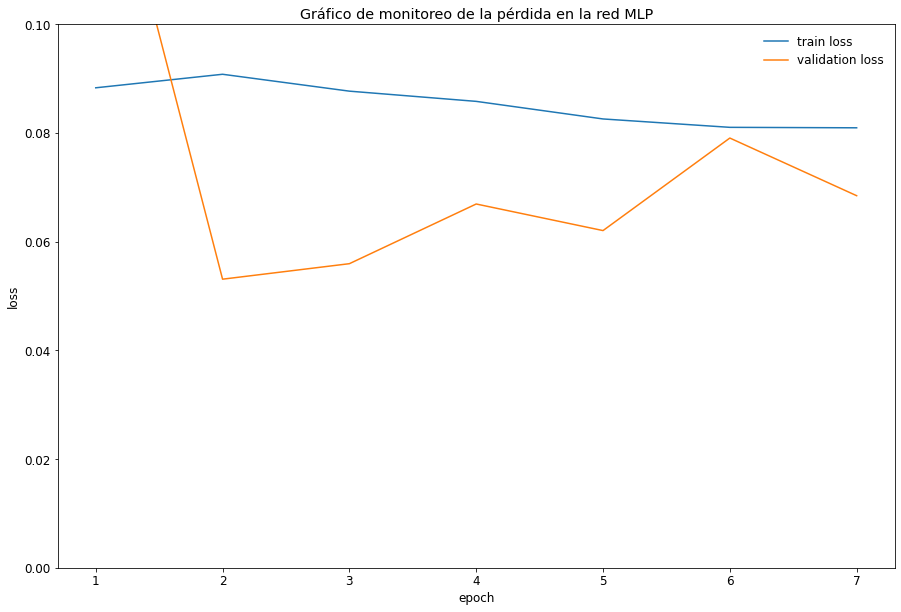

In [51]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

epoch = [i+1 for i in range(len(history.history['loss']))]
ax.plot(epoch, history.history['loss'], label = 'train loss')
ax.plot(epoch, history.history['val_loss'], label = 'validation loss')
ax.set_ylim([0,0.1])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.title('Gráfico de monitoreo de la pérdida en la red MLP') 
plt.legend(loc = 0,frameon=False)
plt.show()

## Red Neuronal LSTM

In [52]:
# The LSTM architecture
lstm_model = Sequential()
# First LSTM layer with Dropout regularisation
lstm_model.add(LSTM(units=50, input_shape=(X_train.shape[1],1), activation='relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(units=1))
# Compiling the RNN
lstm_model.compile(optimizer='adam',loss='mean_squared_error')

In [53]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Fitting to the training set
history_lstm=lstm_model.fit(X_train.reshape(X_train.shape[0],12,1),y_train,epochs=20,batch_size=32, validation_data=(X_test,y_test), callbacks=[early_stopping])

Epoch 1/20
6/6 [==============================] - 1s 30ms/step - loss: 0.0878 - val_loss: 0.0549
Epoch 2/20
6/6 [==============================] - 0s 8ms/step - loss: 0.0854 - val_loss: 0.0545
Epoch 3/20
6/6 [==============================] - 0s 8ms/step - loss: 0.0849 - val_loss: 0.0558
Epoch 4/20
6/6 [==============================] - 0s 8ms/step - loss: 0.0851 - val_loss: 0.0556
Epoch 5/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0848 - val_loss: 0.0548
Epoch 6/20
6/6 [==============================] - 0s 8ms/step - loss: 0.0826 - val_loss: 0.0547
Epoch 7/20
6/6 [==============================] - 0s 8ms/step - loss: 0.0867 - val_loss: 0.0561


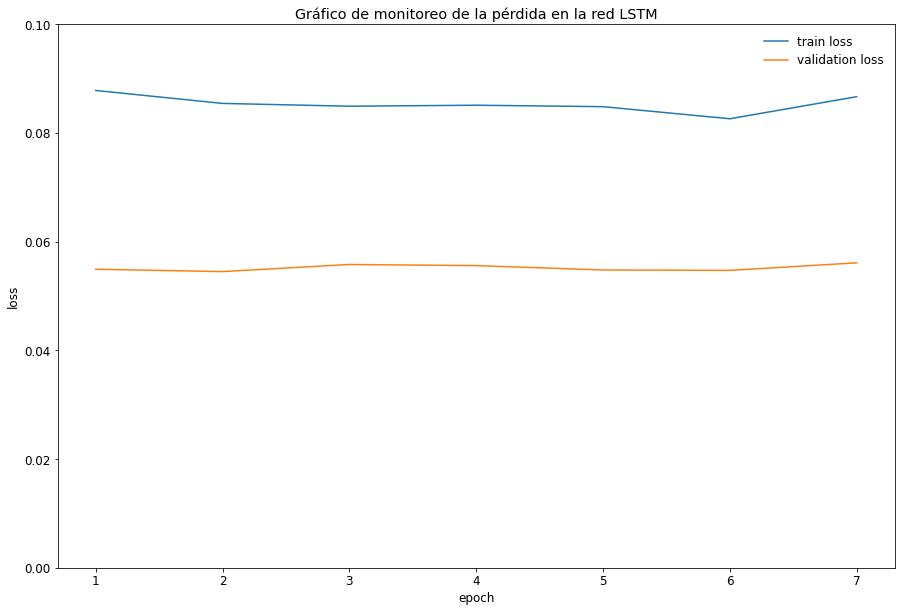

In [55]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

epoch = [i+1 for i in range(len(history_lstm.history['loss']))]
ax.plot(epoch, history_lstm.history['loss'], label = 'train loss')
ax.plot(epoch, history_lstm.history['val_loss'], label = 'validation loss')
plt.title('Gráfico de monitoreo de la pérdida en la red LSTM') 
ax.set_ylim([0,0.1])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.legend(loc = 0,frameon=False)
plt.show()

In [76]:
lstm_predicted_remesas = lstm_model.predict(X_test)
lstm_predicted_remesas.shape

2/2 [==============================] - 0s 2ms/step


(52, 1)

In [ ]:
# Visualizing the results
plt.plot(remesas, color='red',label='Serie original de remesas')
plt.plot(lstm_predicted_remesas, color='blue',label='Pronóstico un paso adelante del modelo LSTM')
plt.title('Gráfico de pronóstico un paso adelante del modelo LSTM')
plt.xlabel('Fecha')
plt.ylabel('Millones de USD')
plt.legend()
plt.show()